# Modeling - RF regression - XGBoost - LGBM

In this notebook we'll modeling the world happiness dataset using three different tree based models. 

The three models are Random Forest Regression, XGBoost and LightGBM.

The models will first be trained using their default parameters to set up a baseline for 'out of the box' performance. 

We'll then tune the hyperparameters of each model using the gp.minimize function from the skpot module.
We'll me minimizing Mean Absolute Error during this process. 

Finally, we'll compare the performace of the tuned models and select the best performer to be trained on the 
entire dataset. 

Once we have selected and trained our final model, we'll explore the feature importances and the 
impact the main features have the target variable. We'll be using the SHAP package for the exploration
of feature impact.

# Table of Contents

- [1.Train-Test Split ](#train_test_split_1)
    - [1.1 Data Reduction for testing](#data_reduction_1_1)
- [2. Define Model Baselines](#model_baselines_2)
- [3. Define Hyperparameter Space](#define_hyperparameter_space_3)
    - [3.1 Objective functions](#objective_functions_3_1)
    - [3.2 Search Spaces](#search_spaces_3_2)
- [4. Run Optimizing Functions](#optimizing_funcs_4)
- [5. Compare optimized models](#compare_tuned_models_5)
    - [5.1 r2 and MAE/ MAPE comparison](#tuned_model_comparison_5_1)
    - [5.2 Actual vs. Predicted comparison](#actual_vs_predicted_comparison_5_2)
    - [5.3 Residuals comparison](#residuals_comparison_5_3)
- [6. Train Best Model on all data](#train_best_model_on_all_data_6)
- [7. Save Final Model for Future Prediction](#save_final_model_7)
- [8. Feature Importance and Impact](#feature_importance_impact_8)
    - [8.1 Feature Importance in best model](#feature_importance_8_1)
    - [8.2 Feature Impact - SHAP Analysis](#feature_impact_8_2)
        - [8.2.1 Log GDP SHAP Analysis](#gdp_shap_8_2_2)
        - [8.2.2 Life Expectancy SHAP Analysis](#life_expectancy_shap_8_2_2)
        - [8.2.3 Social Support SHAP Analysis](#social_support_shap_8_2_3)
        - [8.2.4 Positive Affect SHAP Analysis](#positive_affect_shap_8_2_4)
        - [8.2.5 Regional Indicator SHAP Analysis](#regional_indicator_shap_8_2_5)
- [9. Summary](#summary_9)
- [10. Recommendations for future work](#recs_10)

In [1]:
#Import Modules

import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

import joblib

import lightgbm as lgb
import xgboost as xgb

import shap
shap.initjs()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#import cleaned_data for modeling
df_global = pd.read_csv('../data/interim/cleaned_data.csv', index_col = 0)

In [3]:
df_global.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [5]:
#Convert object type columns to numeric using encoding

country_label_encoder = LabelEncoder()
df_global['Country Name'] = country_label_encoder.fit_transform(df_global['Country Name'])

region_label_encoder = LabelEncoder()
df_global['Regional Indicator'] = region_label_encoder.fit_transform(df_global['Regional Indicator'])

In [6]:
df_global.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,0,6,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,0,6,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,0,6,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,0,6,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,0,6,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [7]:
print(len(df_global))

1851


# 1. Train-Test Split<a class = anchor id=train_test_split_1></a>

### 1.1 Data Reduction for testing<a class=anchor id=data_reduction_1_1></a>

The function below was defined and used to aid in building and testing the notebook. 
The training time for the models was extensive and made testing the notebook difficult. 
The function below reduced the dataset to a more manageable size by randomly selecting a small
percentage of it. 

This subset was used in building the notebook to reduce overall training and compute times. 

The function is not used in the final notebook, and is being included below for reference only.

In [8]:
#Add function to reduce data size so that the notebook will run faster during the building process

def reduce_data(dataframe, percent):
    '''
    This function takes a dataframe as a parameter. It determines the length of the dataframe
    and then randomly selects a number of rows equal to some percentage of the dataframes
    total length 

    The function returns an new dataframe containing some percent of the data of the original
    dataframe

    Parameters:
    dataframe = a non-empty pandas dataframe
    percent = a float between 0 and 1 indicating the percent of the dataframe to retain
    '''

    #determine the length of the incoming dataframe
    df_length = len(dataframe)

    #determine the reduced length using the percent parameter
    reduced_length = int(df_length * percent)

    #Generate list of random numbers as indexs to determine the new dataframe composition
    reduced_index = np.random.randint(low = 0, high = (df_length), size = reduced_length)

    #Subset dataframe based on reduced index list
    reduced_dataframe = dataframe.iloc[reduced_index]

    return reduced_dataframe

In [9]:
#Use the reduce_data function to cut down the dataset by 90% for building the notebook 

#df_global = reduce_data(df_global,0.1)
print(len(df_global))

1851


In [10]:
#Define X and y prior to splitting
target_col = ['Life Ladder']
X = df_global.drop(target_col, axis = 1)
y = df_global[target_col]

In [11]:
#Train Test split global data - using test_size = 0.2 and random_state = 42 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

# 2. Define Model Baselines<a class = anchor id=model_baselines_2></a>

Here we use three different 'out of the box' models with no tuning to set a baseline for performance. 

The three models are Random Forest Regression, XGBoost and LightGBM. 
The data exploration and prepreprocessing notebook was created with RF regression in mind. 
The other models are also tree based, but have a gradient boosting component. We'll be comparing
the three models to see which can give us the best performance. 

The performance of the models after hyperparamter tuning will also be compared to the baseline for that model to give
some idea of the effectivness of the tuning process.

In [12]:
#Random Forest Regression Baseline Model

#Train RF baseline 
rf_reg = RandomForestRegressor(random_state=42)
rf_baseline_model = rf_reg.fit(X_train,y_train.values.ravel())
rf_baseline_model_y_pred_test = rf_baseline_model.predict(X_test)

#Calculate model baseline performance on test set
rf_baseline_r2_score_test = r2_score(y_test,rf_baseline_model_y_pred_test)
rf_baseline_mae_score_test = mean_absolute_error(y_test,rf_baseline_model_y_pred_test)
rf_baseline_mape_score_test = mean_absolute_percentage_error(y_test,rf_baseline_model_y_pred_test)



#XGBoost Baseline Model

#Train XGB baseline 
xg_boost_baseline_model = xgb.XGBRegressor(random_state=42)
xg_boost_baseline_model.fit(X_train, y_train.values.ravel())
xg_boost_baseline_model_y_pred_test = xg_boost_baseline_model.predict(X_test)

#Calculate model baseline performance on test set
xg_boost_baseline_r2_score_test = r2_score(y_test,xg_boost_baseline_model_y_pred_test)
xg_boost_baseline_mae_score_test = mean_absolute_error(y_test,xg_boost_baseline_model_y_pred_test)
xg_boost_baseline_mape_score_test = mean_absolute_percentage_error(y_test,xg_boost_baseline_model_y_pred_test)


#LGBM Baseline Model

#Train LGBM baseline
lgbm_baseline_model = lgb.LGBMRegressor(verbose = -1,random_state=42)
lgbm_baseline_model.fit(X_train, y_train.values.ravel())
lgbm_baseline_model_y_pred_test = lgbm_baseline_model.predict(X_test)

#Calculate model baseline performance on test set
lgbm_baseline_model_r2_score_test = r2_score(y_test,lgbm_baseline_model_y_pred_test)
lgbm_baseline_model_mae_score_test  = mean_absolute_error(y_test,lgbm_baseline_model_y_pred_test)
lgbm_baseline_model_mape_score_test  = mean_absolute_percentage_error(y_test,lgbm_baseline_model_y_pred_test)



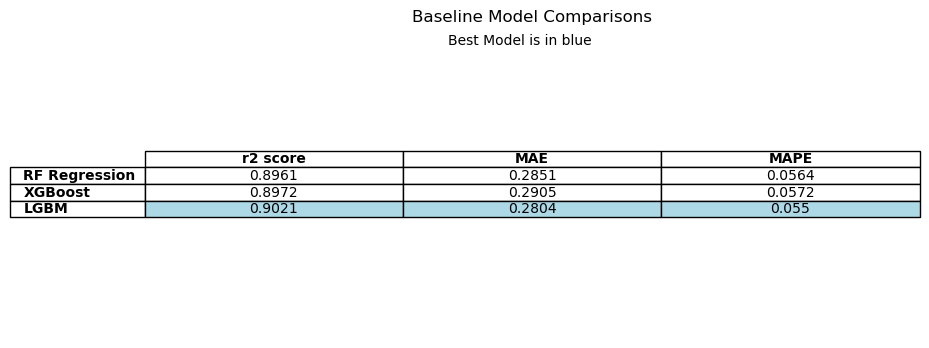

In [13]:
#Create a table summarizing the results of the baseline scores

data = [[round(rf_baseline_r2_score_test,4), round(rf_baseline_mae_score_test,4), round(rf_baseline_mape_score_test,4)],
        [round(xg_boost_baseline_r2_score_test ,4), round(xg_boost_baseline_mae_score_test,4), round(xg_boost_baseline_mape_score_test,4)],
        [round(lgbm_baseline_model_r2_score_test,4), round(lgbm_baseline_model_mae_score_test,4), round(lgbm_baseline_model_mape_score_test,4)]]


row_labels = ['RF Regression', 'XGBoost', 'LGBM']
col_labels = ['r2 score','MAE', 'MAPE']

plt.figure(figsize=(10, 4))
plt.axis('off') 

# Create table
table = plt.table(cellText=data,
                  rowLabels=row_labels,
                  colLabels=col_labels, 
                  loc='center',
                  cellLoc='center',
                  fontsize = 45.0)

highlighted_row = 2
for j in range(len(col_labels)):
    table._cells[(highlighted_row + 1, j)].set_facecolor('lightblue')

for (i, label) in enumerate(row_labels):
    table._cells[(i+1, -1)]._text.set_fontweight('bold')

for (i, label) in enumerate(col_labels):
    table._cells[(0, i)]._text.set_fontweight('bold') 

plt.title("Baseline Model Comparisons")
plt.suptitle("Best Model is in blue", fontsize=10, y=0.87) 

plt.show()


Looks like the best "out of the box" performance is coming from the LightGBM model. All the models
are very close in performance without paramteter tuning. 

# 3. Define Hyperparameter Space<a class=anchor id=define_hyperparameter_space_3></a>

We're using skopt gp_minimize() to search through the hyperparameter space for each function. 

The objective functions for each model and the search space for each model defined below will be 
fed to gp_minimize() as parameters.

The gp_minimize fucntion will be minimizing the Mean Absolute Error of each function.

The objective function for the RF Regressor model is using the OOB score to approximate how the model may behave when given the test set. 
This is being done to save compute time, and to take advantage of the inherent randomness of the RF model. 

The other two models are using normal cross validation to approximate their MAE score on the test set. 

### 3.1 Objective functions<a class=anchor  id=objective_functions_3_1></a>

In [14]:
#Define objective functions for each model


#RF Regressor
def rf_objective(params):
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params
    
    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                          max_depth=(max_depth),
                                          min_samples_split= int(min_samples_split),
                                          min_samples_leaf=int(min_samples_leaf),
                                          max_features = (max_features),
                                          oob_score=True,
                                          random_state=42)
    
    #Cross Validation
    #scores = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5, scoring= 'neg_mean_absolute_error')*-1
    #mean_score = np.mean(scores)
    #return  mean_score

    #OOB
    rf_model.fit(X_train, y_train.values.ravel())
    mae_oob = mean_absolute_error(y_train,rf_model.oob_prediction_)
    return mae_oob


#XG Boost
def xgb_objective(params):
    n_estimators,max_depth,learning_rate,gamma,min_child_weight,subsample,colsample_bytree,colsample_bylevel,colsample_bynode = params

    xgb_model = xgb.XGBRegressor(n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 learning_rate = learning_rate,
                                 gamma = gamma,
                                 min_child_weight = min_child_weight,
                                 subsample = subsample,
                                 colsample_bytree = colsample_bytree,
                                 colsample_bylevel = colsample_bylevel,
                                 colsample_bynode = colsample_bynode,
                                 random_state = 42)
    
    scores = cross_val_score(xgb_model, X_train, y_train.values.ravel(), cv=5, scoring= 'neg_mean_absolute_error')*-1
    mean_score = np.mean(scores)

    return mean_score


#LGBM
def lgbm_objective(params):
    num_leaves,max_depth,learning_rate,n_estimators,subsample_for_bin,min_split_gain,min_child_weight,min_child_samples,subsample,subsample_freq,colsample_bytree,importance_type = params
    
    lgb_model = lgb.LGBMRegressor(num_leaves = num_leaves,
                                  max_depth = max_depth,
                                  learning_rate = learning_rate,
                                  n_estimators = n_estimators,
                                  subsample_for_bin = subsample_for_bin,
                                  min_split_gain = min_split_gain,
                                  min_child_weight = min_child_weight,
                                  min_child_samples = min_child_samples,
                                  subsample = subsample,
                                  subsample_freq = subsample_freq,
                                  colsample_bytree = colsample_bytree,
                                  importance_type = importance_type,
                                  verbose = -1,
                                  random_date = 42
                                  )
    

    scores = cross_val_score(lgb_model, X_train, y_train.values.ravel(), cv=5, scoring= 'neg_mean_absolute_error')*-1
    mean_score = np.mean(scores)

    return mean_score

### 3.2 Search Spaces<a class=anchor id=search_spaces_3_2></a>

In [15]:
#Define the search space for each model

#RF_regressor search space
rf_max_depth_values = [4,8,10]
rf_max_depth_values.append(None)

rf_space = [Integer(9000,11000, name='n_estimators'),
         Categorical(rf_max_depth_values,name='max_depth'),
         Integer(2,10, name='min_samples_split'),
         Integer(1,10, name='min_samples_leaf'),
         Categorical([None,'sqrt'], name='max_features')]


#XGBoost search space
xgb_space = [Integer(9000,11000, name='n_estimators'),
             Integer(0,10, name='max_depth'),
             Real(0.01,0.03, name='learning_rate'),
             Real(0.1,0.5, name='gamma'),
             Integer(1,10, name='min_child_weight'),
             Real(0.5,1, name='subsample'),
             Real(0.5,1, name='colsample_bytree'),
             Real(0.5,1, name='colsample_bylevel'),
             Real(0.5,1, name='colsample_bynode')
                              ]

#LGBM search space
lgb_space = [Integer(15,62, name='num_leaves'),
             Integer(-1,5, name='max_depth'),
             Real(0.05,0.15, name='learning_rate'),
             Integer(50,500, name='n_estimators'),
             Integer(100000,300000, name='subsample_for_bin'),
             Real(0.0,1,name='min_split_gain'),
             Real(0.001,0.01,name='min_child_weight'),
             Integer(10,40,name='min_child_samples'),
             Real(0.5,1,name='subsample'),
             Categorical([0,1],name='subsample_freq'),
             Real(0.5,1,name='colsample_bytree'),
             Categorical(['gain'],name='importance_type'),
             ]

# 4. Run Optimizing Functions <a class =anchor id=optimizing_funcs_4></a>

In [16]:
# Run gp_minimize() for RF Regressor

rf_result = gp_minimize(rf_objective, rf_space, n_calls=100, random_state=42)

# Get the best hyperparameters for the model
rf_best_params = rf_result.x
rf_best_score = rf_result.fun

In [17]:
# Run gp_minimize() for XGBoost

xgb_result = gp_minimize(xgb_objective, xgb_space, n_calls=100, random_state=42)

# Get the best hyperparameters for the model
xgb_best_params = xgb_result.x
xgb_best_score = xgb_result.fun

In [18]:
# Run gp_minimize() for LGBM

lgbm_result = gp_minimize(lgbm_objective, lgb_space, n_calls=100, random_state=42)

# Get the best hyperparameters for the model
lgbm_best_params = lgbm_result.x
lgbm_best_score = lgbm_result.fun

# 5. Compare optimized models<a class = anchor id=compare_tuned_models_5></a>

Using the results of gp_minimize() above we can now plug the best parameters found into their respective models
and compare their performance to select the best one. 

In [74]:
#Instantiate best params models and calculate scores on test set for comparison


#RF Regressor model
rf_best_model = RandomForestRegressor(n_estimators=rf_best_params[0],
                                          max_depth=rf_best_params[1],
                                          min_samples_split= rf_best_params[2],
                                          min_samples_leaf=rf_best_params[3],
                                          max_features = rf_best_params[4],
                                          random_state=42)

rf_best_model.fit(X_train,y_train.values.ravel())
rf_best_model_y_pred = rf_best_model.predict(X_test)

#Calculate model scores on test set
rf_best_model_r2 = r2_score(y_test,rf_best_model_y_pred)
rf_best_model_mae = mean_absolute_error(y_test,rf_best_model_y_pred)
rf_best_model_mape = mean_absolute_percentage_error(y_test,rf_best_model_y_pred)

#Calculate improvement of tuned model over baseline model
rf_score_difference = rf_best_model_mae - rf_baseline_mae_score_test
rf_score_percent_difference = (rf_score_difference/rf_baseline_mae_score_test)*-100


#XGBoost Model
xgb_best_model = xgb.XGBRegressor(n_estimators = xgb_best_params[0],
                                 max_depth = xgb_best_params[1],
                                 learning_rate = xgb_best_params[2],
                                 gamma = xgb_best_params[3],
                                 min_child_weight = xgb_best_params[4],
                                 subsample = xgb_best_params[5],
                                 colsample_bytree = xgb_best_params[6],
                                 colsample_bylevel = xgb_best_params[7],
                                 colsample_bynode = xgb_best_params[8],
                                 random_state=42)

xgb_best_model.fit(X_train,y_train.values.ravel())
xgb_best_model_y_pred = xgb_best_model.predict(X_test)

#Calculate model scores on test set
xgb_best_model_r2 = r2_score(y_test,xgb_best_model_y_pred)
xgb_best_model_mae = mean_absolute_error(y_test,xgb_best_model_y_pred)
xgb_best_model_mape = mean_absolute_percentage_error(y_test,xgb_best_model_y_pred)

#Calculate improvement of tuned model over baseline model
xgb_score_difference =xgb_best_model_mae - xg_boost_baseline_mae_score_test
xgb_score_percent_difference = (xgb_score_difference/xg_boost_baseline_mae_score_test)*-100


#LGBM Model
lgbm_best_model = lgb.LGBMRegressor(num_leaves = lgbm_best_params[0],
                                  max_depth = lgbm_best_params[1],
                                  learning_rate = lgbm_best_params[2],
                                  n_estimators = lgbm_best_params[3],
                                  subsample_for_bin = lgbm_best_params[4],
                                  min_split_gain = lgbm_best_params[5],
                                  min_child_weight = lgbm_best_params[6],
                                  min_child_samples = lgbm_best_params[7],
                                  subsample = lgbm_best_params[8],
                                  subsample_freq = lgbm_best_params[9],
                                  colsample_bytree = lgbm_best_params[10],
                                  importance_type = lgbm_best_params[11],
                                  verbose = -1,
                                  random_state=42
                                  )

lgbm_best_model.fit(X_train,y_train.values.ravel())
lgb_best_model_y_pred = lgbm_best_model.predict(X_test)

#Calculate model scores on test set
lgb_best_model_r2 = r2_score(y_test,lgb_best_model_y_pred)
lgb_best_model_mae = mean_absolute_error(y_test,lgb_best_model_y_pred)
lgb_best_model_mape = mean_absolute_percentage_error(y_test,lgb_best_model_y_pred)


#Calculate improvement of tuned model over baseline model
lgbm_score_difference =lgb_best_model_mae - lgbm_baseline_model_mae_score_test
lgbm_score_percent_difference = (lgbm_score_difference/lgbm_baseline_model_mae_score_test)*-100

### 5.1 r2 and MAE / MAPE comparison <a class = anchor id=tuned_model_comparison_5_1></a>

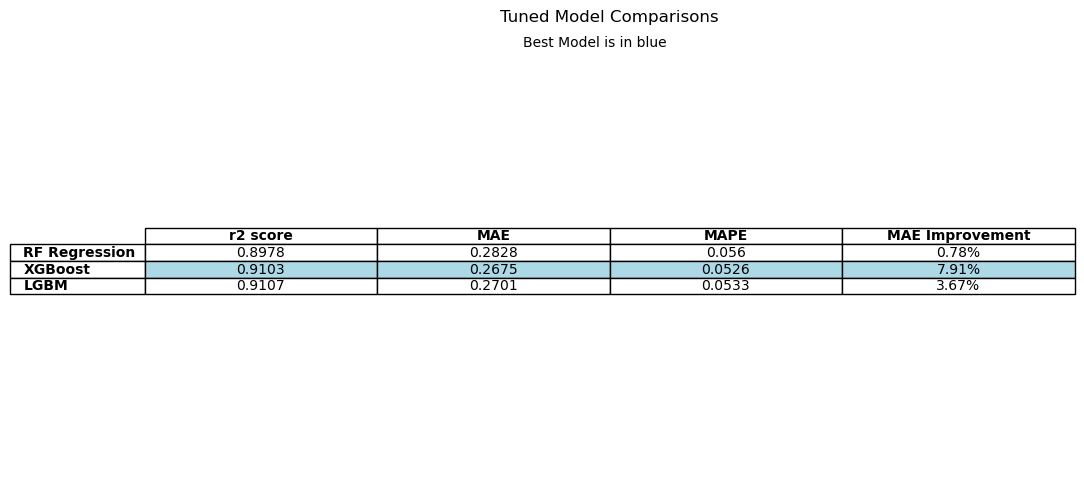

In [75]:
#Create a chart comparing scores of the tuned models

data = [[round(rf_best_model_r2,4),round(rf_best_model_mae,4),(round(rf_best_model_mape,4)),(f'{round(rf_score_percent_difference,2)}%')],
        [round(xgb_best_model_r2,4),round(xgb_best_model_mae,4),(round(xgb_best_model_mape,4)),(f'{round(xgb_score_percent_difference,2)}%')],
        [round(lgb_best_model_r2,4),round(lgb_best_model_mae,4),(round(lgb_best_model_mape,4)),(f'{round(lgbm_score_percent_difference,2)}%')]]


row_labels = ['RF Regression', 'XGBoost', 'LGBM']
col_labels = ['r2 score', 'MAE','MAPE','MAE Improvement']

plt.figure(figsize=(12, 6))
plt.axis('off') 

# Create table
table = plt.table(cellText=data,
                  rowLabels=row_labels,
                  colLabels=col_labels, 
                  loc='center',
                  cellLoc='center',
                  fontsize = 45.0)

highlighted_row = 1
for j in range(len(col_labels)):
    table._cells[(highlighted_row + 1, j)].set_facecolor('lightblue')

for (i, label) in enumerate(row_labels):
    table._cells[(i+1, -1)]._text.set_fontweight('bold')

for (i, label) in enumerate(col_labels):
    table._cells[(0, i)]._text.set_fontweight('bold') 

plt.title("Tuned Model Comparisons")
plt.suptitle("Best Model is in blue", fontsize=10, y=0.87) 


plt.show()

The XGBoost model shows the most improvement over baseline as a result of hyperparameter tuning. 
It is also performing just slightly better than the LGBM model, which had the best performance before tuning. 

Both XGBoost and LGBM are clearly performing better than RF Regression, which is not showing much improvement over 
baseline performance. 

### 5.2 Actual vs. Predicted comparison <a class = anchor id=actual_vs_predicted_comparison_5_2></a>

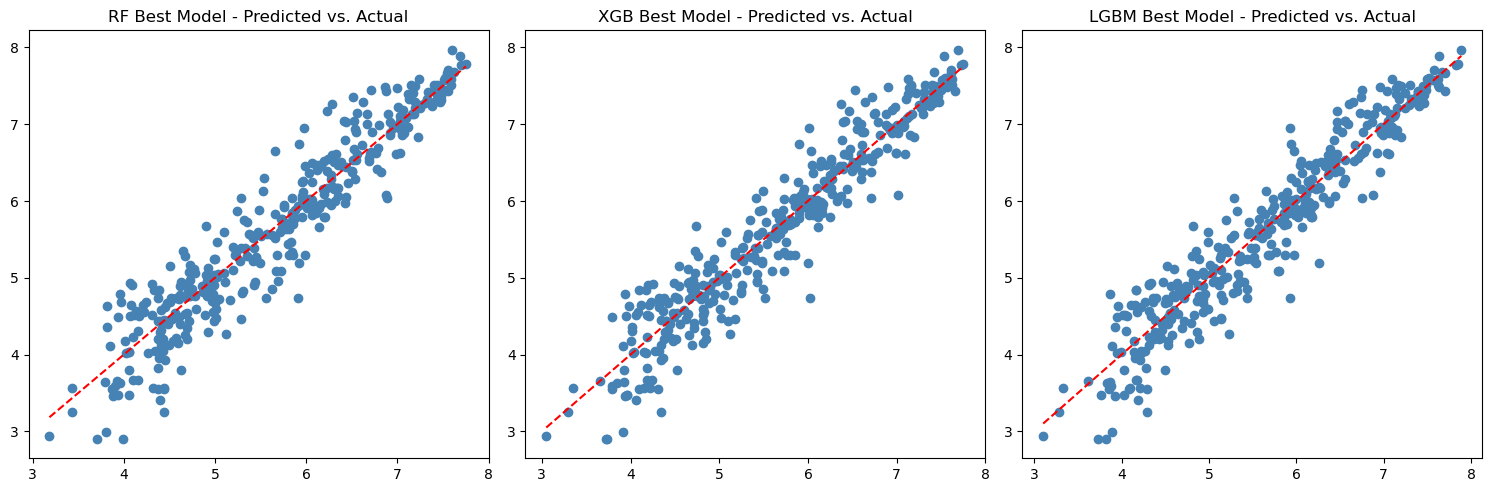

In [32]:
# Data for scatter plots
x1 = rf_best_model_y_pred
y1 = y_test

x2 = xgb_best_model_y_pred
y2 = y_test

x3 = lgb_best_model_y_pred
y3 = y_test

# Create a figure and a grid of subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot the first scatter plot
axs[0].scatter(x1, y1, color='steelblue')
axs[0].plot([min(x1), max(x1)], [min(x1), max(x1)], color='red', linestyle='--')
axs[0].set_xticks([3,4,5,6,7,8])
axs[0].set_title('RF Best Model - Predicted vs. Actual')

# Plot the second scatter plot
axs[1].scatter(x2, y2, color='steelblue')
axs[1].plot([min(x2), max(x2)], [min(x2), max(x2)], color='red', linestyle='--')
axs[1].set_xticks([3,4,5,6,7,8])
axs[1].set_title('XGB Best Model - Predicted vs. Actual')

# Plot the third scatter plot
axs[2].scatter(x3, y3, color='steelblue')
axs[2].plot([min(x3), max(x3)], [min(x3), max(x3)], color='red', linestyle='--')
axs[2].set_title('LGBM Best Model - Predicted vs. Actual')

# Adjust layout to prevent overlap
plt.tight_layout(pad=1.0)

# Show the plot
plt.show()

No real suprises here. Even though the XGBoost model performed better than the other two, it's still
a pretty slight difference when looked at visually. The differences between the XGBoost and LGBM
models in particular seem especially difficult to pick out visually. 

### 5.3 Residuals comparison <a class = anchor id=residuals_comparison_5_3></a>

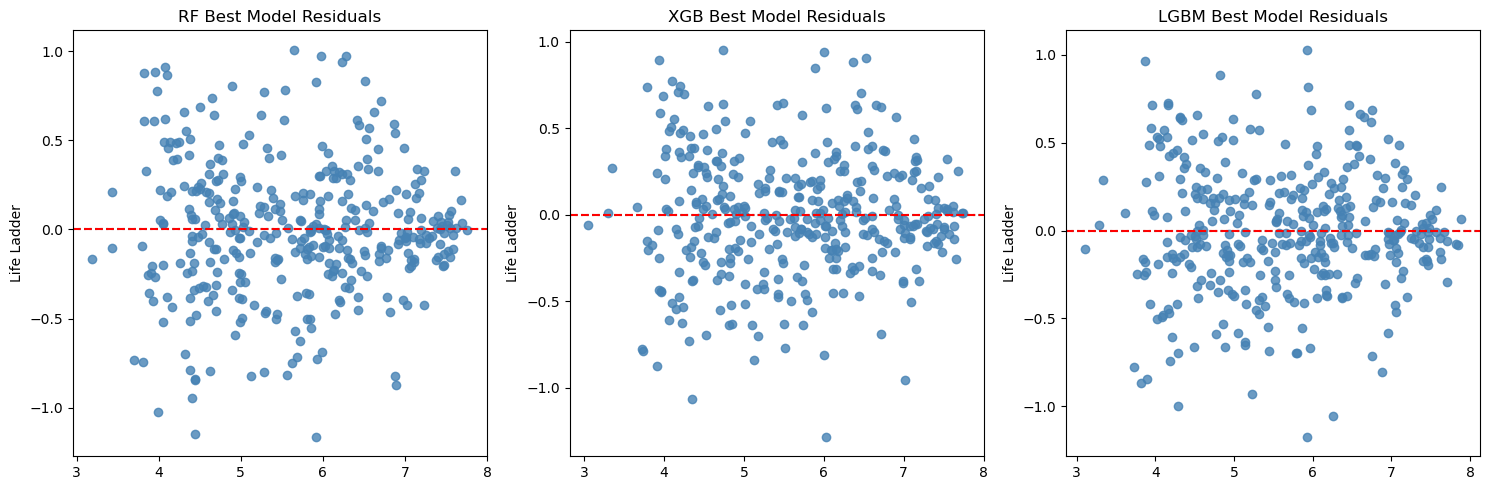

In [34]:
# Data for scatter plots
x1 = rf_best_model_y_pred
y1 = y_test

x2 = xgb_best_model_y_pred
y2 = y_test

x3 = lgb_best_model_y_pred
y3 = y_test

# Create a figure and a grid of subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot the first residual plot
sns.residplot(x=x1, y=y1, ax=axs[0], color='steelblue')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_xticks([3,4,5,6,7,8])
axs[0].set_title('RF Best Model Residuals')

# Plot the second residual plot
sns.residplot(x=x2, y=y2, ax=axs[1], color='steelblue')
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_xticks([3,4,5,6,7,8])
axs[1].set_title('XGB Best Model Residuals')

# Plot the third residual plot
sns.residplot(x=x3, y=y3, ax=axs[2], color='steelblue')
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_title('LGBM Best Model Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


All the residuals are more or less evenly distributed around 0 here. We're not seeing a noticable trend
in any of the models. Again XGB and LGBM look very close if not the same. 

# 6. Train Best Model on all data<a class=anchor id=train_best_model_on_all_data_6></a>

In [35]:
best_model_final = xgb.XGBRegressor(n_estimators = xgb_best_params[0],
                                 max_depth = xgb_best_params[1],
                                 learning_rate = xgb_best_params[2],
                                 gamma = xgb_best_params[3],
                                 min_child_weight = xgb_best_params[4],
                                 subsample = xgb_best_params[5],
                                 colsample_bytree = xgb_best_params[6],
                                 colsample_bylevel = xgb_best_params[7],
                                 colsample_bynode = xgb_best_params[8],
                                 random_state=42)

best_model_final.fit(X,y.values.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.7885890188919127,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=9000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# 7. Save Final Model for Future Prediction<a class = anchor id=save_final_model_7></a>

In [36]:
rel_file_path = '../models'
abs_path = os.path.abspath(rel_file_path)
joblib.dump(best_model_final,abs_path + '/best_model_final.pkl')

['/Users/rossbrinkerhoff/Desktop/Springboard/Springboard_Brinkerhoff/Springboard_Capstone_2/Capstone_2/models/best_model_final.pkl']

# 8. Feature Importance and Impact<a class = anchor id=feature_importance_impact_8></a>

The core question for this project is which of features in the data set has the most effect on the self reported 
happiness scores of the people surveyed. Now that we have a tuned model, we cna try to gain more insight into that question by 
analyzing the feature importance and impact of that final model. 

### 8.1 Feature Importance in best model <a class = anchor id=feature_importance_8_1></a>

In [37]:
#Get the array of feature importances from the model. 
best_model_final_importances = best_model_final.feature_importances_

#Get the list of feature names that the model was trained on
best_model_final_feature_names = X.columns

# Zip the feature names with their importances
model_1_feature_importance_tuples = list(zip(best_model_final_importances, best_model_final_feature_names))

#Sort the features by importance in decending order
model_1_feature_importance_tuples = sorted(model_1_feature_importance_tuples, key=lambda x: x[0], reverse=True)

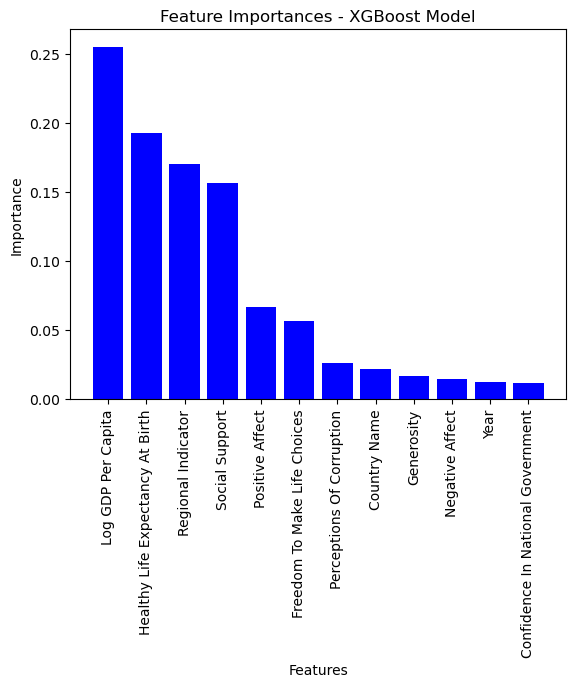

In [38]:
 # Unpack the tuples into separate lists for plotting
importances, features = zip(*model_1_feature_importance_tuples)

# Create a bar chart
plt.bar(features, importances, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances - XGBoost Model')
plt.xticks(rotation=90)
plt.show()

We're seeing the same basic pattern in feature importances here that we saw when modeling this data with
an RF Regressor in the previous notebook. The feature importances have changed in the final XGBoost model, 
but the same major features are still coming forward in the same basic order. 

In all the modeling we've done, Log GDP has been the highest in terms of feature importance. It's been
followed by Healthy Life Expectancy, Regional Indicator, Social Support and Positive Affect in almost all cases, with 
some variation on the order of those non-GDP features in terms of importance depending on the model. 

The notable difference between the above and the feature importances seen with the RF Regressor model is the actual 
level of importance for each of the features. In the RF model, Log GDP was 5+ times higher in importance than the other features. 
It really stood out. Here it's clearly the most important, but by a much smaller margin. 

This could be due to a difference in the models (RF vs. XGB) or it could be partially due to the fact that the importances here
are based on the entire data set, whereas the other modeling we've done was based on a train test split. 

### 8.2 Feature Impact - SHAP Analysis<a class = anchor id=feature_impact_8_2></a>

For the shap anaylsis below, we train a new version of our best model on a new set of our total
data but lacking the Country Name feature. 

We've removed this feature for the SHAP analysis because this feature it was encoded for training the main model but the assigned numbers 
are arbitrary. This is fine for encoding, but the shap analysis we'll be using will be setting up a relaitonship between higher and lower 
feature values and high or low shap values. 

In the case of countries, a higher number does not mean anything, it's just standing in for a categorical variable, so a SHAP analysis would not make sense for this feature. 

This does make some intuitive sense in that country names themselves are arbitrary. The feature was considered for elimination earlier in the project but was ultimatley retained because pre-processing indicated that including the country names aided in prediction performance.


The "Regional Indicator" feature has a similar issue with encoding, but in that case there are far fewer regions to deal with. 
It also makes intutive sense that the region a given country is in would have a meaningful effect on life in the country. If nothing else, 
we might say that countries in the same regions would have an influence economically and culturally on the other countries in the region. 
In this sense we might look for some effect that the region feature has on the target variable, that we would not expect from the country name feature. 

We'll explore this issue further in section 8.2.5 below.

In [39]:
#Get rid of everything to do with locality and do the shap analysis on the XGBoost model with tuned paramets but without the locality cols (Country Name, Regional Indicator.)

X_shap = X.drop(columns = ['Country Name'])

In [41]:
best_model_final_shap = xgb.XGBRegressor(n_estimators = xgb_best_params[0],
                                 max_depth = xgb_best_params[1],
                                 learning_rate = xgb_best_params[2],
                                 gamma = xgb_best_params[3],
                                 min_child_weight = xgb_best_params[4],
                                 subsample = xgb_best_params[5],
                                 colsample_bytree = xgb_best_params[6],
                                 colsample_bylevel = xgb_best_params[7],
                                 colsample_bynode = xgb_best_params[8],
                                 random_state=42)



best_model_final_shap.fit(X_shap,y.values.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.7885890188919127,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=9000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [42]:
explainer = shap.Explainer(best_model_final_shap,X_shap)
shap_values = explainer(X_shap)

100%|===================| 1845/1851 [03:38<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


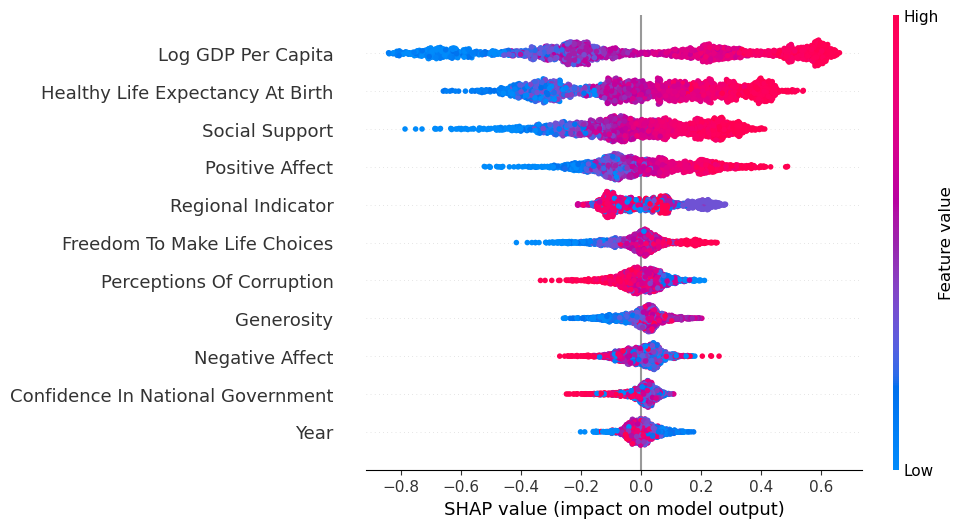

In [45]:
shap.plots.beeswarm(shap_values, max_display = 15)

The SHAP value results above are similar to the feature importances in section 8.1. We see the same 5 features indicates as 
having the highest impace, albet in a slightly different order. We'll examine each of these five features in detail below.

For all features except Regional Indicator, we see that very positive feature values have a high postive impact, and very low feature values have a negative impact. The values for Regional indicator here can be ignored because the "high" and "low" values shown are still encoded. 
We'll break those down below. 

It's interesting to know that not all the features are balanced in their impact. 'Freedom to make life choices',for example, doesn't have a really large positive effect at high feature values. However, it can have a large negative effect when the feature values are low. 
The same sort of imbalance can be seen with the Social support feature, where a very low value will have a larger negative impact than a very high value. 

The X-axis scale itself is actually imbalanced, with the highest postive SHAP values arounf 0.6 and the lowest SHAP values around -0.8. 

In a very general sense, this would seem to indicate that a very low feature value has a larger impact than a very high one. These outsize effects don't seem to kick in when it comes to less extreme values for the features. In all cases we see a lot of our values clustered in the middle with relatviely small impacts. The high impacts come from the extreme low and high feature values. 

We'll look at the five highest impact features in detail below to get a better sense of where the transition point is between the lower impace values and the higher impact values. 


#### 8.2.1 Log GDP SHAP Analysis <a class =anchor id=gdp_shap_8_2_2></a>

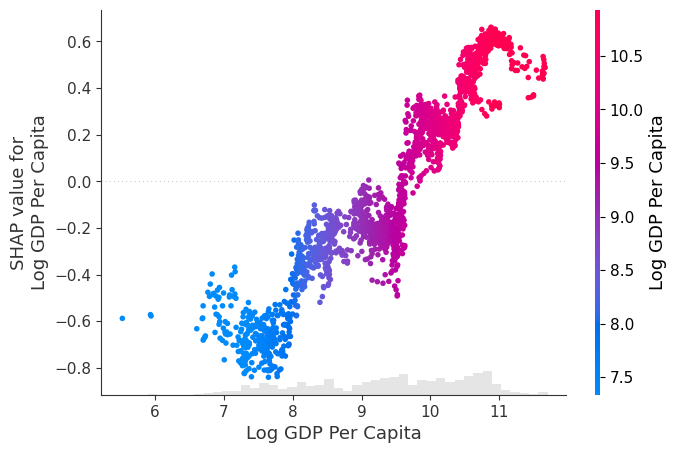

In [81]:
shap.plots.scatter(shap_values[:,'Log GDP Per Capita'], color = shap_values[:,'Log GDP Per Capita'])


We can see clearly the transiton for the Log GDP feature here. It has a negative impact in the 
target variable below about 9.5, with very large negative impacts below about 8. Positive impacts really
start to kick off around 10.5. We' also see an interesting series of jumps here between some of the values. 
For example the, a feature value of 10 has a significanly lower positive impact compared to a value of about 10.5. 

The range of values around 0 corresponds to the KMeans analysis done in the prior notebook. In that 
anaylsis, we identified two major clusters of countries with a transitional group. These clusters were pretty clearly
defined as was the tranitional group of countres that moved from one cluster to another depending on the year when the 
data was collected. 

For the the Log GDP feature, the IQR for the transitional group was from 9 to about 10. 
This corresponds closely with what we see above, as that is the range of values within which the imact of the 
feature moves from being negative to being positive. 

#### 8.2.2 Life Expectancy SHAP Analysis <a class = anchor id=life_expectancy_shap_8_2_2></a>

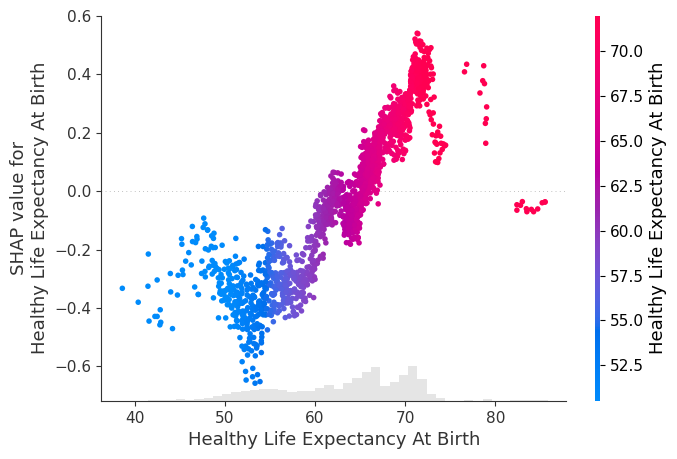

In [82]:
shap.plots.scatter(shap_values[:,'Healthy Life Expectancy At Birth'], color = shap_values[:,'Healthy Life Expectancy At Birth'])

We see here again a sort of series of jumps but overall the pattern for the life expectancy feature
is much more linear. It's similar to Log GPD, which it does correlate with, but it's by no means an exact mirror. 

As with the GDP feature above, we're seeing here relatively positive impacts above about 67 and a clustering
of the most negative imacts below about 55. 

The IQR for this feature in the KMeans analysis was approximately 63-67, which again lies right on the boundary
where this feature moves from negatiive to positive in terms of impact. 


#### 8.2.3 Social Support SHAP Analysis <a class = anchor id=social_support_shap_8_2_3></a>

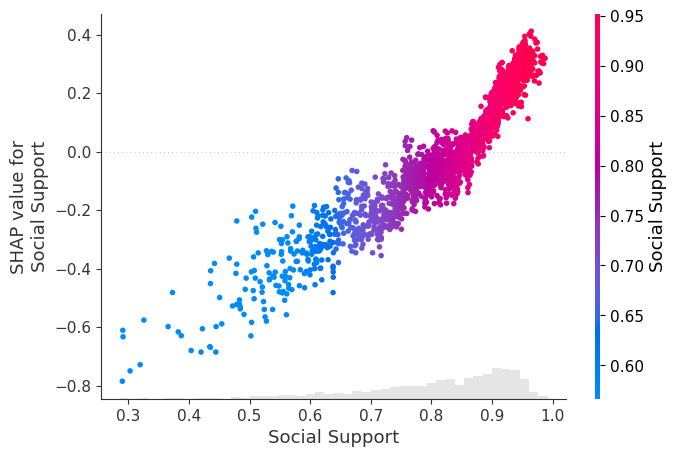

In [83]:
shap.plots.scatter(shap_values[:,'Social Support'], color = shap_values[:,'Social Support'])

This is a much more linear looking plot. It's a more or less smooth linear transition from the 
lowest feature value with the most negative impact to the highest with the most positive. 

That being said, we can see that most of the values for this feature actually have a negatvie impact on the target variable. 
At the the most extreme low value the negative impace is 2x the most extreme high value. This shows the imbalance
that we noted above in the swarm plot. A low value for this feature has a lot more negative imact than a high value does positive impact. 

The transition point from negative to positive here is between the feature values 0.8 and 0.9.
This again corresponds very nicely to the transitional group values noted in the KMeans analysis.
The IQR for this feature in the transitonal group there was approximately 0.8-0.9

#### 8.2.4 Positive Affect SHAP Analysis <a class = anchor id=positive_affect_shap_8_2_4></a>

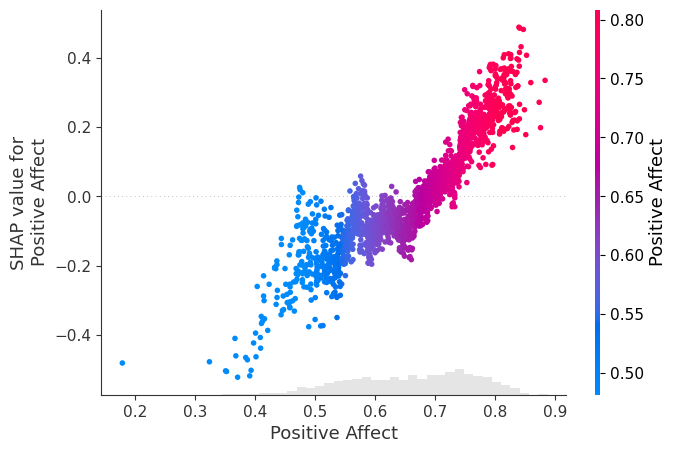

In [84]:
shap.plots.scatter(shap_values[:,'Positive Affect'], color =shap_values[:,'Positive Affect'] )

There is a larger range of feature values here that appear to have small impacts on the target variable. 
In the other major features we saw a relatively smaller range of values in this sor of low impact space. 
We still see that the extreeme low and high values have corresponding low and high impacts, but we're not seeing 
quite the imbalance that was present in some of the other features. 

As with the other features we've examined, the KMeans zone of transition matches up with the impact analysis. 
In this case the IQR for the KMeans transtional group was approcimately 0.55-0.72. 
This is not as clean as the other features. The IQR in this case is indicating an area of small but negative impact, it's not really straddling the line from positive to negative impact in the same way.  

#### 8.2.5 Regional Indicator SHAP Analysis <a class = anchor id=regional_indicator_shap_8_2_5></a>

In [67]:
data = shap_values[:,'Regional Indicator']

data_dict = {}

data_dict['values'] = data.values
data_dict['base_values'] = data.base_values
data_dict['data'] = data.data

regional_indicator_shap = pd.DataFrame(data_dict)

In [68]:
regional_indicator_shap.head()

,values,base_values,data
0,-0.051901,5.530237,6.0
1,-0.015650,5.530237,6.0
2,-0.001895,5.530237,6.0
3,-0.006752,5.530237,6.0
4,-0.040820,5.530237,6.0


In [69]:
original_labels = region_label_encoder.inverse_transform(df_global['Regional Indicator'])
label_mapping = dict(zip(df_global['Regional Indicator'], original_labels))

regional_indicator_shap['data'] = regional_indicator_shap['data'].replace(label_mapping)

In [70]:
regional_indicator_shap.head()

,values,base_values,data
0,-0.051901,5.530237,South Asia
1,-0.015650,5.530237,South Asia
2,-0.001895,5.530237,South Asia
3,-0.006752,5.530237,South Asia
4,-0.040820,5.530237,South Asia


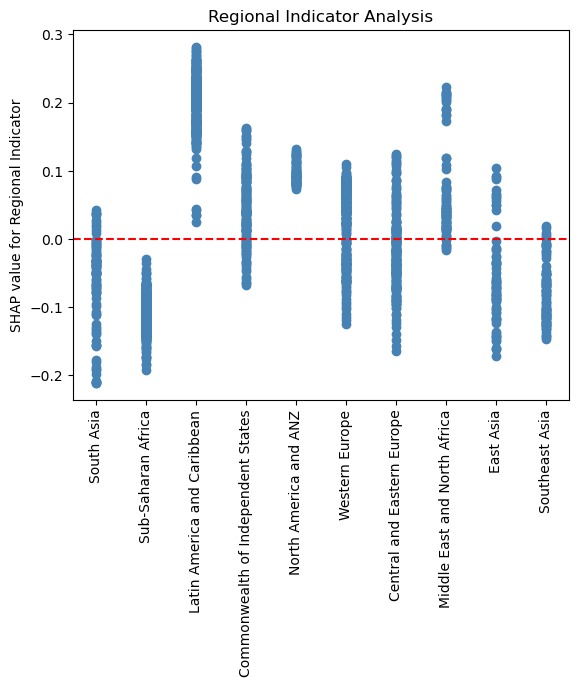

In [86]:
plt.scatter(x = regional_indicator_shap['data'], y=regional_indicator_shap['values'], color = 'steelblue' )

plt.ylabel('SHAP value for Regional Indicator')
plt.xticks(rotation = 90)

plt.axhline(y=0.0,color = 'red', linestyle = '--')

plt.title('Regional Indicator Analysis')

plt.show()

The impact of region on the target variable as laid out above are in many ways the most interesting finding here. 
In all the analysis so far, the most important and impactful feature has been Log GDP. With that in mind, we would expect 
to see regions with generally stronger economies having a larget positive impact. We see that im some cases above, notably with the 
North America and ANZ region. However, we don't see the same pattern with Western Europe, which we know also has strong GDP based on prior analysis. 

The biggest suprise is perhaps Latin America and the Caribbean, where we see even higher positive impact than the North American and ANZ region. The Middle East and North Africa also show a positive impact out of proprtion with what we would expect based on economics. 

A regional analysis has not been part of the this project, but it might be a good area for future analysis to tease out 
what combination of factors in the Latin America and the Caribbean and Middle East and North Africa regions accounts for this difference. 

It's also possible that these differences are largely artifacts of data collection, which we've learned is by no means fully representative 
of every country in every region. Even so, these differences in regional impact are unexpected and would warrent further analysis at a later time.

# 9. Summary<a class = anchor id=summary_9></a>

In the notebook above we performed hyperparameter tuning on 3 different models of our data. The models were all tree based, consisting of a Random Forest Regressor, an XGBoost model and a LightGBM model. 

All three models were trained in their ‘out of the box’ configuration first to establish a baseline of performance, and we then tuned using a gaussian search of their hyperparameter space (gp.minimize() from skopt.)
The performance of the tuned models was compared based on their r2. MAE and MAPE scores. 

The XGBoost model showed the best improvement over baseline and the best overall performance and was selected as the final model to be trained on the entire data set. This model was then saved for any future prediction needs. 

With the model built we examined the feature importances of the XGBoost model and performed a SHAP analysis to better understand the impact of the various data features on our target variable (Life Ladder Score). Details of the SHAP analysis can be found in sections 8.2 to 8.2.5 above. 
The most important and impactful features were examined separately in those sections. 

We were also able to connect the SHAP results to the KMeans modeling work done in a prior notebook. For the features examined, we found that the transitional zones identified in cluster analysis corresponded well with the various feature value ranges where feature impact transitioned from negative to positive. This was an unexpected and interesting finding.  

Regarding the larger question at the heart of the project, we must conclude that the answer is complex. We wanted to know which of the featues in the data were most significant in terms of their correlation with the Life Ladder Score. We can't say there is causation, but we can gain an intuition for the relationships. GDP is a major component in terms of importance and impact when looking at it's effect on the Life Ladder scores in our data. It's no doubt significant, but it's not the whole story. Multiple other features some into play, some of which have outsize negative or positive impacts depending on the feature value. The major features to consider are as follows:

1. Log GDP feature - Economic Strength
2. Healthy Life Expectancy Feature - Life Spans
3. Social Support Feature - Strength of Personal Social Networks
4. Positive Affect Feature - Previous days enjoyment
5. Regional Indicator Feature - Geographic location

Understanding interactions between these features provides a good basis for understanding
the Life Ladder scores for various countries, and how those scores might change as the situation in the country changes. 

# 10. Recommendations for future work<a class = anchor id=recs_10></a>

Based on the analysis here, there are two main avenues where future work might be helpful in improving our understanding of this data set:

### 1. Regional Modeling
The analaysis here has focused on the data we have for all years and all countries, basically the globe. 
Modeling at the level of the individual country was not successful, but regional modeling has gone largely unexplored in the work so far. 
The finding above that some regions have an impact on the target variable that seems to be uncorrelated with their economics is interesting and bears further scruitiny.

### 2. Feature Engineering and/or Changes in data collection
The modeling process in this project suffered because some data points, in particular data points for the 
"Perceptions of Corruption" and "Confidence in National Government" features were not available for all countries and all years. 
This seems to be because conducting national surveys of populations on these questions is not possible in some areas and some political structures. This limitation meant that some very large and important countries (most notably China), could not be modeled because there was no complete information in the data set. 

We know that all the features are important in the sense that removing enay of them seems to lessen model perofrmances. 
However, it is also clear from the analysis of both the feature importances and the SHAP values above that some features are much more
impactful than others. 

The model would be improved if data from those key features could be used for all countries, without totally sacrificing the problematic features. The missing government and corruption feature values could be imputed in some way or a proxy feature could be developed that captures the same sort of information on various governemnts without having to actually ask the survey questions. The latter course of action seems best, since it is difficult to determine how a value reflecting self reported public perception of a government in a particular country and year could be reliably imputed. Development of a proxy value, and remodeling of the data set using that value, would be another possible area for future projects.  